# セマンティック・セグメンテーション
## 一般的な画像分類
画像全体に対して、この画像は何かを出力する。
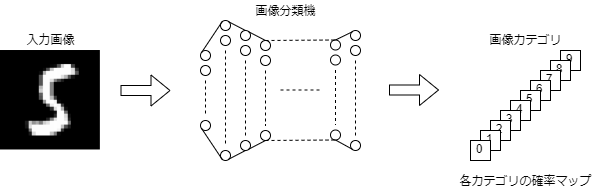

## セマンティック・セグメンテーション
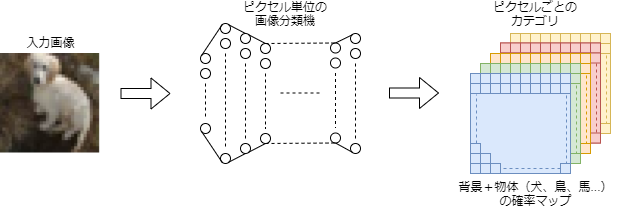

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.datasets import MNIST

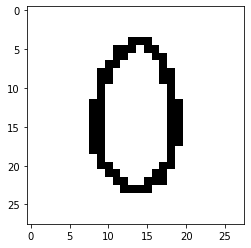

In [24]:
class SegmentationMNIST(Dataset):
    def __init__(self, root, train, threshold):
        super().__init__()
        self.mnist = MNIST(root = root, train = train)
        self.threshold = threshold
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, index):
        image, label = self.mnist[index]
        image = np.array(image, dtype = np.uint8)
        mask  = np.where(image > self.threshold, label, 255) # 背景クラスを255に設定
        return image, mask
        
train_data = SegmentationMNIST(root = "../data", train = True,  threshold = 127)
test_data  = SegmentationMNIST(root = "../data", train = False, threshold = 127)
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader  = DataLoader(test_data,  batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["test"])
# 要素を取り出す
imgs, masks = next(batch_iterator)
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(masks[0].squeeze().numpy(), cmap = "gray")

In [13]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # エンコーダー部
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 64, 3, stride = 1, padding = 1), # [N, 64, 28, 28]
                nn.ReLU(inplace = True),

                nn.Conv2d(64, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),
                
                nn.Conv2d(64, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(128, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True)
            )
        ])
        
        # ボトルネック部
        self.bottle_neck = nn.Sequential(
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, stride = 1, padding = 1, bias = False), # [N, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, 3, stride = 1, padding = 1, bias = False), # [N, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = False) # [N, 128, 14, 14]
        )
        
        # デコーダー部
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128 + 256, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(128, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = False) # [N, 128, 28, 28]
            ),
            nn.Sequential(
                nn.Conv2d(64 + 128, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(64, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(64, num_classes, 1, stride = 1, padding = 0) # [N, 11, 28, 28]
            )
        ])
    
    def forward(self, x):
        h_list = [] # 特徴マップを格納するリスト
        for block in self.encoder:
            x = block(x)
            h_list.append(x)
            
        x = self.bottle_neck(x)
        
        for h, block in zip(h_list[::-1], self.decoder):
            x = block(torch.cat([h, x], dim = 1))
        
        return x
    
model = SimpleUNet(in_channels = 1, num_classes = 11)